## 사용자 기반 협업필터링을 이용한 영화 추천 시스템
- **목표** : 사용자 기반 협업필터링을 이용하여 영화 추천 알고리즘을 구현한다.


- ** Work Flow **

    1. 네이버영화 페이지에서 영화 평을 10개 이상으로 한 유저의 'id'와 유저가 평가한 영화들의 '제목'. '장르', '평점'을 크롤링한다. 이때, 크롤링 한 데이터는 MySQL을 이용하여 AWS 서버에 수집한다.
    [<크롤링을 위한 함수 코드 click>](https://github.com/Yooonkyung/Movie_recommendation/blob/master/01.%20crawling.py)
    [<크롤링 실행 코드 click>](https://render.githubusercontent.com/view/ipynb?commit=87ea8453e02810ea4699f1295ef7246cec5cd674&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f596f6f6f6e6b79756e672f4d6f7669655f7265636f6d6d656e646174696f6e2f383765613834353365303238313065613436393966313239356566373234366365633563643637342f30322e253230646f5f637261776c696e672e6970796e62&nwo=Yooonkyung%2FMovie_recommendation&path=02.+do_crawling.ipynb&repository_id=107040258&repository_type=Repository#%ED%81%AC%EB%A1%A4%EB%A7%81)
    
    2. 사용자 기반 협업필터링(User-based Collaborative Filtering) 알고리즘을 이용하여 추천 시스템을 구현
    
    
- 개인프로젝트 (기간: 2017.10.20~2017.11.06)

## 1. IMPORT

In [1]:
import pandas as pd
import numpy as np

from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pickle
import random

## 2. DATA LOAD
- AWS에 수집한 데이터를 LOAD

In [2]:
# movie_customer 데이터 불러오기
df_mc = pd.read_csv('movie_customer.csv', encoding = 'euc-kr')
print(df_mc.shape)
df_mc.head()

(3277, 8)


,customer_id,gender,age,age_group,married,kids_under12,area,subs_start_year
0,C5001,F,51,50대,M,N,용산구,2015
1,C5002,M,22,20대,S,N,강남구,2015
2,C5003,F,33,30대,M,Y,서대문구,2015
3,C5004,F,24,20대,M,N,서대문구,2015
4,C5005,F,35,30대,M,N,마포구,2015


In [3]:
# movie_down 데이터 불러오기
df_md = pd.read_csv('movie_down.csv', encoding = 'euc-kr')
print(df_md.shape)
df_md.head()

(116464, 6)


,customer_id,item_id,down_date,down_year,down_month,down_weekday
0,C5001,I-1038,2015-01-08,2015,2015M01,Thu
1,C5001,I-1003,2015-01-17,2015,2015M01,Sat
2,C5001,I-1017,2015-01-17,2015,2015M01,Sat
3,C5001,I-1028,2015-01-19,2015,2015M01,Mon
4,C5001,I-1036,2015-01-20,2015,2015M01,Tue


In [4]:
# movie_inventory 데이터 불러오기
df_mi = pd.read_csv('movie_inventory.csv', encoding = 'euc-kr')
print(df_mi.shape)
df_mi.head()

(106, 32)


,item_id,contract_year,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,...,director,Genre_1,Genre_2,Genre_3,actor_1,actor_2,actor_3,contract_price,studio_score,price_class
0,I-1013,2015,tt0468569,The Dark Knight,2008,07-18-2008,152,PG-13,PG-13,9.0,...,Christopher Nolan,Action,Crime,Drama,Christian Bale,Heath Ledger,Aaron Eckhart,2700,10,10
1,I-1097,2019,tt4154756,Avengers: Infinity War,2018,04-27-2018,149,PG-13,PG-13,8.5,...,Anthony Russo,Action,Adventure,Sci-Fi,Robert Downey Jr.,Chris Hemsworth,Mark Ruffalo,2700,10,10
2,I-1106,2019,tt1477834,Aquaman,2018,12-21-2018,143,PG-13,PG-13,7.0,...,James Wan,Action,Adventure,Fantasy,Jason Momoa,Amber Heard,Willem Dafoe,2295,10,1
3,I-1070,2017,tt2975590,Batman v Superman: Dawn of Justice,2016,03-25-2016,151,PG-13,PG-13,6.5,...,Zack Snyder,Action,Adventure,Sci-Fi,Ben Affleck,Henry Cavill,Amy Adams,2295,10,1
4,I-1026,2015,tt1375666,Inception,2010,07-16-2010,148,PG-13,PG-13,8.8,...,Christopher Nolan,Action,Adventure,Sci-Fi,Leonardo DiCaprio,Joseph Gordon-Levitt,Ellen Page,2700,10,10


In [5]:
# movie_customer 데이터 불러오기
df_mm = pd.read_csv('movie_meta.csv', encoding = 'euc-kr')
print(df_mm.shape)
df_mm.head()

(1668, 40)


,movie_id,title,release_year,release_date,runtime,mpa_rating,mpa_rating_origin,imdb_score,votes,reviews_users,...,contract_price,studio_score,price_class,writer_1,writer_2,actor_1,actor_2,actor_3,description,storyline
0,tt0472033,9,2009,09-09-2009,79,PG-13,PG-13,7.1,127563,267,...,2195,6,1,Pamela Pettler,Shane Acker,Christopher Plummer,Martin Landau,John C. Reilly,A rag doll that awakens in a postapocalyptic f...,In a world destroyed in a war between man and ...
1,tt0478087,21,2008,03-28-2008,123,PG-13,PG-13,6.8,216963,302,...,2295,10,1,Peter Steinfeld,Allan Loeb,Jim Sturgess,Kevin Spacey,Kate Bosworth,"""21"" is the fact-based story about six MIT stu...","Ben Campbell is a young, highly intelligent, s..."
2,tt0453562,42,2013,04-12-2013,128,PG-13,PG-13,7.5,79204,234,...,2700,10,10,Brian Helgeland,NaN,Chadwick Boseman,Harrison Ford,Nicole Beharie,"In 1947, Jackie Robinson becomes the first Afr...","In 1946, Jackie Robinson is a Negro League bas..."
3,tt0416449,300,2006,03-09-2007,117,R,R,7.7,702777,2142,...,2700,10,10,Zack Snyder,Kurt Johnstad,Gerard Butler,Lena Headey,Dominic West,King Leonidas of Sparta and a force of 300 men...,In the Battle of Thermopylae of 480 BC an alli...
4,tt0450385,1408,2007,06-22-2007,104,PG-13,PG-13,6.8,245370,622,...,2145,4,1,Matt Greenberg,Scott Alexander,John Cusack,Tony Shalhoub,Len Cariou,A man who specialises in debunking paranormal ...,The cynical and skeptical writer Mike Enslin w...


# movie_down과 movie_customer 결합

In [6]:
# movie_dow과 nmovie_customer 결합
# customer_id를 기준
# 왼쪽 데이터 고유값 기준 (left)
df_mc_md = pd.merge(df_md, df_mc, how = 'left', on = ['customer_id'])
print(df_mc_md.shape)
df_mc_md

(116464, 13)


,customer_id,item_id,down_date,down_year,down_month,down_weekday,gender,age,age_group,married,kids_under12,area,subs_start_year
0,C5001,I-1038,2015-01-08,2015,2015M01,Thu,F,51,50대,M,N,용산구,2015
1,C5001,I-1003,2015-01-17,2015,2015M01,Sat,F,51,50대,M,N,용산구,2015
2,C5001,I-1017,2015-01-17,2015,2015M01,Sat,F,51,50대,M,N,용산구,2015
3,C5001,I-1028,2015-01-19,2015,2015M01,Mon,F,51,50대,M,N,용산구,2015
4,C5001,I-1036,2015-01-20,2015,2015M01,Tue,F,51,50대,M,N,용산구,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116459,C8277,I-1087,2018-09-21,2018,2018M09,Fri,M,37,30대,S,N,강남구,2018
116460,C8277,I-1090,2018-09-29,2018,2018M09,Sat,M,37,30대,S,N,강남구,2018
116461,C8277,I-1088,2018-10-24,2018,2018M10,Wed,M,37,30대,S,N,강남구,2018
116462,C8277,I-1091,2018-10-25,2018,2018M10,Thu,M,37,30대,S,N,강남구,2018


In [7]:
df_mc_md.columns

Index(['customer_id', 'item_id', 'down_date', 'down_year', 'down_month',
       'down_weekday', 'gender', 'age', 'age_group', 'married', 'kids_under12',
       'area', 'subs_start_year'],
      dtype='object')

# movie_down, movie_customer와 movie_inventory 결합

In [8]:
# movie_down, movie_customer와 movie_inventory 결합
# item_id를 기준
# 왼쪽 데이터 고유값 기준 (left)
df_mc_md_mi = pd.merge(df_mc_md, df_mi, how = 'left', on = ['item_id'])
print(df_mc_md_mi.shape)
df_mc_md_mi

(116464, 44)


,customer_id,item_id,down_date,down_year,down_month,down_weekday,gender,age,age_group,married,...,director,Genre_1,Genre_2,Genre_3,actor_1,actor_2,actor_3,contract_price,studio_score,price_class
0,C5001,I-1038,2015-01-08,2015,2015M01,Thu,F,51,50대,M,...,Francis Lawrence,Action,Adventure,Mystery,Jennifer Lawrence,Liam Hemsworth,Jack Quaid,2600,6,10
1,C5001,I-1003,2015-01-17,2015,2015M01,Sat,F,51,50대,M,...,Andrew Adamson,Adventure,Family,Fantasy,Georgie Henley,Skandar Keynes,William Moseley,2295,10,1
2,C5001,I-1017,2015-01-17,2015,2015M01,Sat,F,51,50대,M,...,Michael Bay,Action,Adventure,Sci-Fi,Shia LaBeouf,Megan Fox,Josh Duhamel,2145,4,1
3,C5001,I-1028,2015-01-19,2015,2015M01,Mon,F,51,50대,M,...,Michael Bay,Action,Adventure,Sci-Fi,Shia LaBeouf,Rosie Huntington-Whiteley,Josh Duhamel,2145,4,1
4,C5001,I-1036,2015-01-20,2015,2015M01,Tue,F,51,50대,M,...,Pierre Coffin,Animation,Adventure,Comedy,Steve Carell,Kristen Wiig,Benjamin Bratt,2295,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116459,C8277,I-1087,2018-09-21,2018,2018M09,Fri,M,37,30대,S,...,Kyle Balda,Animation,Adventure,Comedy,Steve Carell,Kristen Wiig,Trey Parker,2295,10,1
116460,C8277,I-1090,2018-09-29,2018,2018M09,Sat,M,37,30대,S,...,Andy Muschietti,Horror,NaN,NaN,Jaeden Martell,Jeremy Ray Taylor,Sophia Lillis,2195,6,1
116461,C8277,I-1088,2018-10-24,2018,2018M10,Wed,M,37,30대,S,...,Jon Watts,Action,Adventure,Sci-Fi,Tom Holland,Michael Keaton,Robert Downey Jr.,2700,10,10
116462,C8277,I-1091,2018-10-25,2018,2018M10,Thu,M,37,30대,S,...,Taika Waititi,Action,Adventure,Comedy,Chris Hemsworth,Tom Hiddleston,Cate Blanchett,2700,10,10


In [9]:
df_raw = df_mc_md_mi.drop(['country_2','country_3', 'Genre_2', 'Genre_3'], axis = 1)

In [10]:
df_raw.columns

Index(['customer_id', 'item_id', 'down_date', 'down_year', 'down_month',
       'down_weekday', 'gender', 'age', 'age_group', 'married', 'kids_under12',
       'area', 'subs_start_year', 'contract_year', 'movie_id', 'title',
       'release_year', 'release_date', 'runtime', 'mpa_rating',
       'mpa_rating_origin', 'imdb_score', 'votes', 'reviews_users',
       'reviews_critics', 'budget', 'income_usa', 'income_ww',
       'theater_opening', 'theater_total', 'country_1', 'studio', 'director',
       'Genre_1', 'actor_1', 'actor_2', 'actor_3', 'contract_price',
       'studio_score', 'price_class'],
      dtype='object')

In [11]:
df_raw.shape

(116464, 40)

In [12]:
df1 = df_raw[['customer_id','title','imdb_score','Genre_1']]

In [13]:
df1.tail(2)

,customer_id,title,imdb_score,Genre_1
116462,C8277,Thor: Ragnarok,7.9,Action
116463,C8277,The Hangover,7.7,Comedy


In [14]:
df_copy = df1.copy()
df_copy.tail(2)

,customer_id,title,imdb_score,Genre_1
116462,C8277,Thor: Ragnarok,7.9,Action
116463,C8277,The Hangover,7.7,Comedy


## 3. DATA 탐색

#### (1) 전체 유저와 영화의 수 확인

In [15]:
user_num = df1.customer_id.unique().shape[0]
movie_num = df1.title.unique().shape[0]

print("유저의 수는 {}명 이고,\n영화의 수는 {}개 입니다.".format(user_num, movie_num))

유저의 수는 3277명 이고,
영화의 수는 94개 입니다.


#### (2) 평점을 많이 남긴 유저 TOP 10

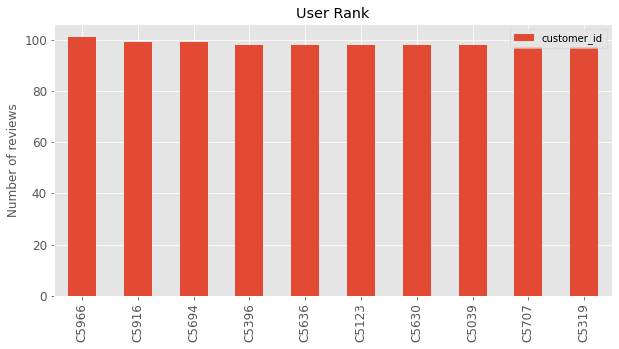

In [16]:
user_top_10 = df1.customer_id.value_counts()[:10]

plt.style.use('ggplot')
user_top_10.plot(kind = 'bar', title = 'User Rank',
                            figsize = (10, 5), legend = True, fontsize = 12)
plt.ylabel("Number of reviews", fontsize = 12)
plt.show()

#### (3) 유저들로 부터 평점을 많이 받은 영화 TOP 10

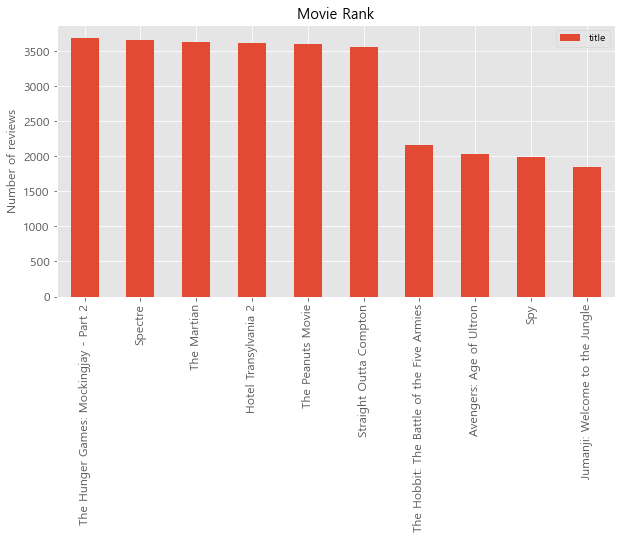

In [17]:
# matplotlib에서 한글 사용
font_name = font_manager.FontProperties(fname = "c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family = font_name)

movie_top_10 = df1.title.value_counts()[:10]

plt.style.use('ggplot')
movie_top_10.plot(kind = 'bar', title = 'Movie Rank',
                            figsize = (10, 5), legend = True, fontsize = 12)
plt.ylabel("Number of reviews", fontsize = 12)
plt.show()

#### (4) Score 랭킹

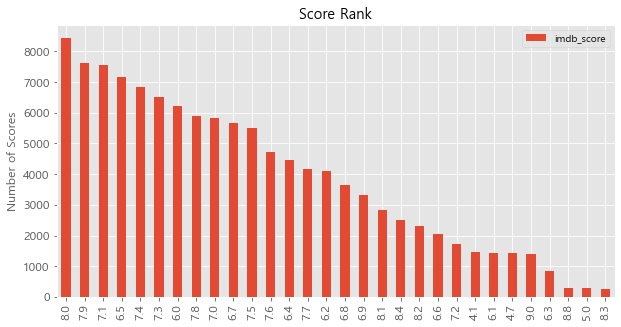

In [18]:
plt.style.use('ggplot')
df1.imdb_score.value_counts().plot(kind = 'bar', title = 'Score Rank',
                            figsize = (10, 5), legend = True, fontsize = 12)
plt.ylabel("Number of Scores", fontsize = 12)
plt.show()

## 4. 협업필터링을 이용한 영화 추천 알고리즘
다음과 같은 순서로 진행함
1. 계산을 용이하게 하기 위해 각 원소 ** $ a_{ij} $ ** 가 유저(i)가 영화(j)에 준 평점(score)을 의미하는 유틸리티행렬(U)를 만든다.
2. target 유저(t)의 number가 들어오면 코사인 유사도를 이용하여 각 사용자의 짝 유사도를 계산한다. 이를 이용하여 유저(t)와 가장 비슷한 유저(s) K명을 찾는다.
2. 유저(t)와 유사한 K명의 유저(s)들이 아이템에 대해 평가한 평점을 이용하여, 유저(t)가 아직 평가하지 않은 영화(j)의 평점을 예측한다. 이때, 유저(s)의 평점을 가중평균하여 계산한다.
3. 성능 평가를 통해 알맞은 K를 구한다.
4. 예측한 평점을 이용하여 유저(t)에게 영화 3편을 추천한다.

### I. 유틸리티행렬

#### (1) LabelEndoder를 이용하여 user와 title을 수치화 한다.

In [19]:
def execute_labeling(column_name):
    Lec = LabelEncoder()
    df_copy = df1.copy()
    df_label = pd.DataFrame(Lec.fit_transform(df_copy[column_name].values), columns = [column_name+'_label'])
    return df_label

df_user = execute_labeling('customer_id')
df_title = execute_labeling('title')

print(len(df_user['customer_id_label'].value_counts()))
print(len(df_title['title_label'].value_counts()))

df_copy = df1.copy()    # copy df
df_copy = df_copy.drop(df_copy.columns[[0, 1]], axis = 1)    # delete 'user', 'title' columns
df_label = pd.concat([df_user, df_title, df_copy], axis = 1)    # 라벨링한 컬럼과 기존 데이터프레임 합치기

df_label.tail(5)

3277
94


,customer_id_label,title_label,imdb_score,Genre_1
116459,3276,12,6.3,Animation
116460,3276,33,7.4,Horror
116461,3276,53,7.5,Action
116462,3276,83,7.9,Action
116463,3276,67,7.7,Comedy


#### (2) 유저와 영화 제목이 column이고 각 원소가 평점인 DataFrame 생성

In [20]:
movie_list = list(df1['title'].unique())
movie_list = sorted(movie_list, key=str)
df_matrix = pd.DataFrame(columns = ['customer_id'] + movie_list)
df_matrix    #결과확인

,customer_id,American Sniper,Ant-Man,Avatar,Avengers: Age of Ultron,Batman v Superman: Dawn of Justice,Captain America: Civil War,Captain America: The Winter Soldier,Coco,Daddy's Home,...,Toy Story 3,Trainwreck,Transformers,Transformers: Dark of the Moon,Transformers: Revenge of the Fallen,Trolls,Up,Wonder Woman,X-Men: Apocalypse,Zootopia


In [21]:
%%time

user_num = len(df_label.customer_id_label.unique())
movie_num = len(df_label.title_label.unique())

user_score_list = []    # df_matrix에서 'user' 컬럼을 제외한 컬럼. 즉, title 컬럼
for num in range(0, user_num):
    
    user_score_list = [0 for i in range(movie_num)]    # 값을 0으로 초기화
    df_tmp = df_label[df_label['customer_id_label'] == num]    # 각 유저별로 묶는다
    
    #print(df_tmp.head(2))
    for j in df_tmp.index:
        
        user_score_list[df_tmp.title_label[j]] = df_tmp.imdb_score[j] # user가 평가한 영화가 있다면 score를 채워넣는다
                
    df_matrix.loc[num] = [num] + user_score_list    # 행채우기

Wall time: 36.5 s


#### (3) pickle

In [22]:
# 유틸리티행렬 pickle 저장
file = df_matrix
directory = open('utilitymatrix', 'wb')
pickle.dump(file, directory)
directory.close()

In [23]:
user_name = list(df1['customer_id'].unique())
user_name = sorted(user_name, key = str)
user_name = pd.DataFrame(user_name)
user_name.columns = ['user_name']

# user_name pickle 저장
file_user = user_name
directory_user = open('user_name', 'wb')
pickle.dump(file_user, directory_user)
directory_user.close()

In [24]:
# pickle로 저장한 user_name data frame open
f = open('user_name', 'rb')
user_name = pickle.load(f)
user_name = user_name

In [32]:
# pickle로 저장한 유틸리티 행렬 DATA LOAD
f = open('utilitymatrix', 'rb')
utilitymatrix = pickle.load(f)

df = utilitymatrix
df

,customer_id,American Sniper,Ant-Man,Avatar,Avengers: Age of Ultron,Batman v Superman: Dawn of Justice,Captain America: Civil War,Captain America: The Winter Soldier,Coco,Daddy's Home,...,Toy Story 3,Trainwreck,Transformers,Transformers: Dark of the Moon,Transformers: Revenge of the Fallen,Trolls,Up,Wonder Woman,X-Men: Apocalypse,Zootopia
0,0.0,7.3,7.3,0.0,0.0,0.0,7.8,7.8,8.4,0.0,...,0.0,0.0,0.0,6.2,6.0,6.5,8.2,7.4,0.0,0.0
1,1.0,7.3,0.0,0.0,0.0,0.0,0.0,7.8,0.0,6.2,...,0.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,7.3,7.3,7.8,0.0,0.0,0.0,0.0,8.4,6.2,...,0.0,6.2,0.0,0.0,0.0,6.5,8.2,7.4,6.9,0.0
3,3.0,0.0,7.3,7.8,7.3,0.0,7.8,0.0,0.0,0.0,...,0.0,0.0,7.0,6.2,6.0,6.5,0.0,7.4,0.0,8.0
4,4.0,0.0,7.3,7.8,0.0,0.0,0.0,0.0,8.4,6.2,...,0.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,3272.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4,0.0,0.0
3273,3273.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4,0.0,0.0
3274,3274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4,0.0,0.0
3275,3275.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.5,0.0,0.0,0.0,0.0


In [33]:
df_concat = pd.concat([user_name, df], axis = 1)
df_concat

,user_name,customer_id,American Sniper,Ant-Man,Avatar,Avengers: Age of Ultron,Batman v Superman: Dawn of Justice,Captain America: Civil War,Captain America: The Winter Soldier,Coco,...,Toy Story 3,Trainwreck,Transformers,Transformers: Dark of the Moon,Transformers: Revenge of the Fallen,Trolls,Up,Wonder Woman,X-Men: Apocalypse,Zootopia
0,C5001,0.0,7.3,7.3,0.0,0.0,0.0,7.8,7.8,8.4,...,0.0,0.0,0.0,6.2,6.0,6.5,8.2,7.4,0.0,0.0
1,C5002,1.0,7.3,0.0,0.0,0.0,0.0,0.0,7.8,0.0,...,0.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C5003,2.0,7.3,7.3,7.8,0.0,0.0,0.0,0.0,8.4,...,0.0,6.2,0.0,0.0,0.0,6.5,8.2,7.4,6.9,0.0
3,C5004,3.0,0.0,7.3,7.8,7.3,0.0,7.8,0.0,0.0,...,0.0,0.0,7.0,6.2,6.0,6.5,0.0,7.4,0.0,8.0
4,C5005,4.0,0.0,7.3,7.8,0.0,0.0,0.0,0.0,8.4,...,0.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3272,C8273,3272.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4,0.0,0.0
3273,C8274,3273.0,0.0,0.0,0.0,0.0,0.0,7.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4,0.0,0.0
3274,C8275,3274.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.4,0.0,0.0
3275,C8276,3275.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.5,0.0,0.0,0.0,0.0


### II. 유저(t)와 유사한 K명의 유저(s)를 찾고, 유저(t)가 아직 평가하지 않은 영화의 평점을 예측한다.

#### (1) 유사도 척도
- 유틸리티 행렬로 부터 각 사용자의 짝 유사도를 계산하기 위해서 코사인 유사도를 사용한다.
- 코사인 유사도(cosine similarity)는 내적공간의 두 벡터(여기서 벡터는 각 유저들이 평가한 평점들)간 각도의 코사인값을 이용하여 측정된 벡터간의 유사한 정도를 의미한다. 1에 가까워 질수록 유사도가 높아진다. 즉, 같은 아이템에 대해 평점이 비슷한 유저일수록 유사도가 높아진다.
- similarity = cos($\theta$) = $ \frac {A \cdot B}{\parallel A \parallel \cdot \parallel B \parallel} $ = $ \frac {\sum_{i=1}^{n}{A_{i} \times B_{i}}}{ \sqrt{\sum_{i=1}^{n}{{(A_{i})}^2}} \times \sqrt{\sum_{i=1}^{n}{{(B_{i})}^2}}}$

In [34]:
def cosine_similarity(data_name):    
    from sklearn.metrics.pairwise import cosine_distances
    similarity = 1 - cosine_distances(data_name)    # sklearn은 정의와 반대이므로 1에서 빼준다.
    return similarity

cos_sim = cosine_similarity(df)    # data set으로 df를 넣음
print(cos_sim.shape)
cos_sim

(3277, 3277)


array([[1.00000000e+00, 4.18353432e-01, 4.40072515e-01, ...,
        6.40276310e-04, 1.85910258e-03, 1.78200080e-03],
       [4.18353432e-01, 1.00000000e+00, 2.68852260e-01, ...,
        3.50486200e-02, 3.58202038e-02, 3.57274312e-02],
       [4.40072515e-01, 2.68852260e-01, 1.00000000e+00, ...,
        4.48565480e-02, 4.49410427e-02, 4.44725577e-02],
       ...,
       [6.40276310e-04, 3.50486200e-02, 4.48565480e-02, ...,
        1.00000000e+00, 9.99953411e-01, 9.99968697e-01],
       [1.85910258e-03, 3.58202038e-02, 4.49410427e-02, ...,
        9.99953411e-01, 1.00000000e+00, 9.99957071e-01],
       [1.78200080e-03, 3.57274312e-02, 4.44725577e-02, ...,
        9.99968697e-01, 9.99957071e-01, 1.00000000e+00]])

#### (2) K명의 유저(s)를 이용하여 유저(t)가 예측하지 않은 영화의 평점 예측
- 계산된 유사도를 통해 NearestNeighbors를 이용하여 K명의 유저(s)를 클러스터링 한다.

In [36]:
class Basic(object):
    
    def __init__(self, user_name, neigh_num):
        self.user_name = user_name
        self.neigh_num = neigh_num
    
    """유저의 이름이 들어오면 유저 번호로 변환"""
    def convert_user_num(self):
        
        user_name_list = list(df_concat['user_name'].unique())
        
        for num in range(len(user_name_list)):
            if user_name_list[num] == self.user_name:
                user_num = num
        
        return user_num
    
    
    """target 유저와 유사한 유저 K명을 찾고, cosine 유사도를 이용하여 거리를 구한다"""
    def find_near_neighbor(self):
    
        from sklearn.neighbors import NearestNeighbors
        
        user_num = Basic.convert_user_num(self)
            
        KNN = NearestNeighbors(n_neighbors = self.neigh_num, metric = 'cosine')    # n_neighbors에는 본인이 포함되기 때문에 +1을 해준다.
        KNN.fit(df)    # data set은 utility matrix인 df를 사용
        similar_distance, similar_users = KNN.kneighbors(df)
    
        similars = {}    #유사한 유저와 거리를 dict형식으로 저장
    
        # 유사한 유저
        similar_users = similar_users[user_num][1:]
        similars['sim_users'] = list(similar_users)
    
        # 유사한 유저들과의 거리
        similar_distance = similar_distance[user_num][1:]
        similars['sim_distance'] = similar_distance
    
        return similars
    
    
    """target유저 + 유사한 유저 K명으로 이루어진 새로운 data frame 형성하고, narray 형식으로 반환"""
    def near_neighbors_narray(self):
    
        similars = Basic.find_near_neighbor(self)
        similiar_users_list = similars['sim_users']
        similiar_distances = similars['sim_distance']

        columns = list(df.columns)
        new_df = pd.DataFrame(columns = columns)
    
        for i in range(len(similiar_users_list)):
        
            def concat_row(i):
                neighbor_df = df[df['customer_id'] == similiar_users_list[i]]
                return neighbor_df
        
            neighbor_df = pd.concat([new_df, concat_row(i)])
            new_df = neighbor_df
            
        narray = new_df.values
        narray = narray[:, 1:]
        
        return narray

In [37]:
class Calculation_rating(Basic):
    
    def __init__(self, user_name, neigh_num):
        Basic.__init__(self, user_name, neigh_num)
        
    """가중평균 값으로 아이템에 대한 target 유저의 평점을 예측"""
    def predict_rating(self):
        
        narray = Basic.near_neighbors_narray(self)    #narray 받음
        similars = Basic.find_near_neighbor(self)
        
        similiar_distances = similars['sim_distance']
    
        rating_list = []    # 가중평균값을 담는 리스트
    
        # 범위 0 ~ K-1
        for col_num in range(narray.shape[1]):
        
            sum = 0
            rating = 0
            for i in range(1, len(narray[:, col_num])):
                 sum += float(narray[:, col_num][i]) * float(similiar_distances[i])
            rating = sum/similiar_distances.sum()
        
            if rating < 0:
                rating = 0    # 만약 가중평균값이 0보다 작으면 0점으로 함
            elif rating > 10:
                rating = 10    # 만약 가중평균값이 10보다 크면 10점으로 함
            else:
                rating = int(rating)    # 평점은 정수형
    
            rating_list.append(rating)

        return rating_list
        
    
    """target 유저의 평점을 리스트로 변환하는 함수"""
    def original_rating(self):
        
        user_num = Basic.convert_user_num(self)
    
        # target 유저의 평점을 narray로 변환
        target_df = df[df['customer_id'] == user_num]
        target_narray = target_df.values
        target_narray = target_narray[:, 1:]    # user column 삭제
    
        #narray로 변환된 target 유저의 평점을 리스트로 변환
        target_user_rating_list = []
        for i in range(target_narray.shape[1]):
            raw_rating = int(target_narray[0][i])
            target_user_rating_list.append(raw_rating)
    
        return target_user_rating_list

### III. 성능평가
- 성능평가를 통해 알맞은 이웃의 수(K)를 찾는다. 이때, MSE(Mean squared error)를 이용한다.
- MSE는 통계적추정의 정확성에 대한 질적인 척도로 잔차(실제값과 추정값과의 차이)가 얼마인가를 알려준다. 값이 작을수록 추정의 정확성이 높아진다.
- MSE = $ \frac {1}{n} \sum _{i=1}^{n}{(y_{i} - \hat{y}_{i})^2} $

In [38]:
# MSE를 이용한 성능평가 함수
def evaluation(neigh_num):
    
    from sklearn.metrics import mean_squared_error
    
    neigh_num = neigh_num
    rmse = 0
    user_name_list = list(df_concat['user_name'].unique())
    
    for user_name in user_name_list:
        
        cal = Calculation_rating(user_name, neigh_num)
        predict_list = cal.predict_rating()
        original_list = cal.original_rating()
        rmse_onebyone = mean_squared_error(original_list, predict_list)
        
        rmse += rmse_onebyone
        
    rmse = rmse/len(user_name_list)

    return print('이웃의 수가 {}일때, MSE 값은 {}입니다.'.format(neigh_num-1, rmse))

먼저 K값을 20~60 사이의 값으로 지정하여 비교

In [ ]:
neigh_num = [21, 41, 61]    # 이웃의 수가 20명, 40명, 60명이 됨
for num in neigh_num:
    evaluation(num)

이웃의 수(K)가 감소할수록 MSE값이 감소했다. 이는 K값이 작아질수록 성능이 좋아진다는 것을 의미한다.

K의 수를 10이하로 하여 성능평가를 다시 시도했다.

In [ ]:
neigh_num = [6, 8, 11]    # 이웃의 수가 5명, 7명, 10명이 됨
for num in neigh_num:
    evaluation(num)

이웃의 수(K)가 7명일때 MSE값이 가장 작았고, 성능이 가장 좋은 것으로 판단하여 이웃의 수(K)를 7로 채택했다.

### IV. 예측한 평점을 이용하여 유저(t)에게 영화 3편을 추천

In [ ]:
class UBCF(Calculation_rating):
    
    def __init__ (self, user_name, neigh_num):
        Basic.__init__(self, user_name, neigh_num)
        Calculation_rating.__init__(self, user_name, neigh_num)        
        
    def recommen_movie_list(self):
        
        user_num = Basic.convert_user_num(self)
        predict_list = Calculation_rating.predict_rating(self)
        original_list = Calculation_rating.original_rating(self)
        all_movie_list = list(df.columns)[1:]    # 전체 영화 리스트
        
        """
        target 유저가 이미 평가했던 영화 외의 영화를 추천받기 위해
        target 유저의 평점이 0이면, 가중평균값을 넣고 그렇지 않으면 0을 넣는다
        """
        temp_list = []
        for i in range(len(predict_list)):
            if int(original_list[i]) != 0:
                temp_list.append(0)
            else:
                temp_list.append(int(predict_list[i]))
        
        # 4점 이상인 영화들만 선택하여 index를 추천 리스트에 담는다.
        recommen_list_index =[]
        for i in range(len(temp_list)):
            if temp_list[i] >= 5:
                recommen_list_index.append(i)
        
        # recommen_list_index로 부터 영화 제목을 str로 저장
        recommen_list_str = []
        for i in recommen_list_index:
            recommen_list_str.append(all_movie_list[i])
        
        """전체 영화 리스트에서 target 유저가 이미 평가한 영화를 제거"""
        already_rating_movie_num = [i for i in range(len(temp_list)) if temp_list[i] == 0]
        user_movie_list = [all_movie_list[i] for i in range(len(all_movie_list)) if i not in already_rating_movie_num]

        
        final_dict = {}
        final_dict['by_rating'] = recommen_list_str
        final_dict['by_delete'] = user_movie_list
        
        return final_dict
    
    
    """영화 추천 실행 함수"""
    def recommendation(self):
        
        user_number = Basic.convert_user_num(self)
        movie_dict = UBCF.recommen_movie_list(self)
        
        by_rating_list = movie_dict['by_rating']
        by_delete_list = movie_dict['by_delete']
        
        # 만약 추천 리스트가 3개 이상이라면 가중평균 리스트에서 3편의 영화를 추천리스트에서 추천
        # 그렇지 않으면 유저가 이미 평가했던 영화를 제외한 영화 리스트에서 추천
        if len(by_rating_list) >= 3:
            recommendation_selection = random.sample(by_rating_list, 3)
        else:
            if len(by_delete_list) >= 3 :
                recommendation_selection = random.sample(by_delete_list, 3)
            else:
                recommendation_selection = random.sample(by_delete_list, 1)
            
        user_name = df_concat['user_name'][user_number]    # user number를 user의 아이디로 변경
    
        print('{}님을 위한 추천 영화 입니다.'.format(user_name))
        return print(recommendation_selection)             

## V. 실행 결과

In [ ]:
recommendation_0tae = UBCF('0tae', 8)
recommendation_0tae.recommendation()

In [ ]:
recommendation_ddm2 = UBCF('ddm2', 8)
recommendation_ddm2.recommendation()

In [ ]:
recommendation_xfee = UBCF('xfee', 8)
recommendation_xfee.recommendation()

In [ ]:
recommendation_skki = UBCF('skki', 8)
recommendation_skki.recommendation()

In [ ]:
recommendation_wjdw = UBCF('wjdw', 8)
recommendation_wjdw.recommendation()